# Convolutional Neural Networks

## Preliminaries

In this practical session you will implement and train several Convolutional Neural Networks (CNNs) using the Keras framework with a Tensorflow backend. If you are not already familiar with Keras, you can go over the [following tutorial](https://github.com/tueimage/essential-skills/blob/master/keras.md). More detailed information on the different functionalities can be found in the [Keras library documentation](https://keras.io/). 

Note that for this set of exercise CPU-only Tensorflow, which you should already have installed, is sufficient (i.e. GPU-support is not required but it will make your experiments run faster). 

You are also required to use the `gryds` package for data augmentation that you can install directly from git: `pip install git+https://github.com/tueimage/gryds/`.

You also have to install the Keras deep learning framework (if you have not done so already) by running `conda install keras`. Note that there are two implementations of Keras, one from https://keras.io/ and another one that ships with Tensorflow. Here we use the former. 

## MNIST
We will first train a simple CNN to classify handwritten digits using the MNIST dataset. This dataset is often referred to as the "Hello world!" example of deep learning because it can be used to quickly illustrate a small neural network in action (and obtain a decent classification accuracy in the process). More information on it can be found [here](http://yann.lecun.com/exdb/mnist/).

First, let's load the dataset and visualize some images.

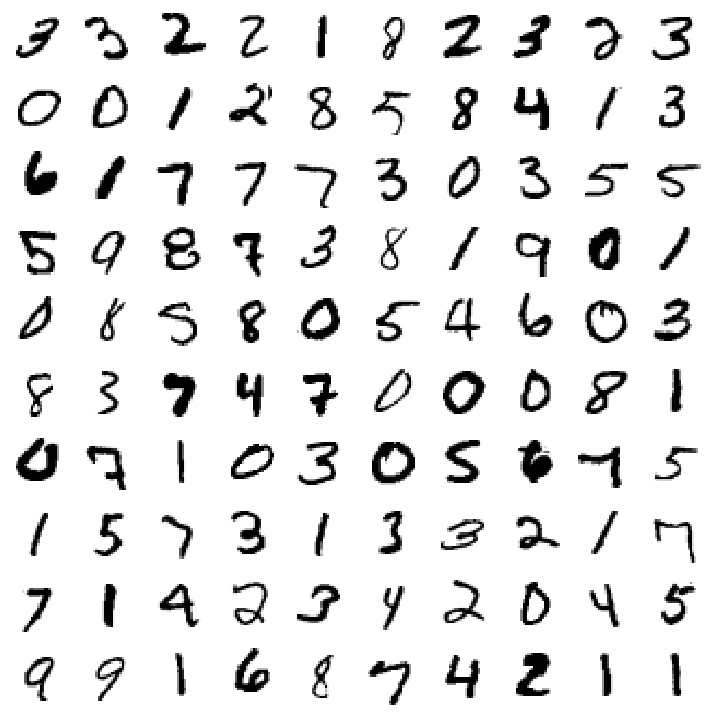

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# load the MNIST the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# scale the image intensities to the 0-1 range
x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)

# convert the data to channel-last
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# convert the labels to one-hot encoded
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

def plot_images(images, dim=(10, 10), figsize=(10, 10), title=''):
    
    plt.figure(figsize=figsize)
    
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()
    
plot_images(x_train[np.random.randint(0, x_train.shape[0], size=100)].reshape(100, 28, 28))

The MNIST classification task is quite simple: given an image, predict the digit that it contains. Thus, this is a 10-class classification problem.

Let's define a simple network for the handwritten digit classification.

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

Compile and train the network (note that this could take a while).

In [8]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/5
469/469 [==============================] - 97s 207ms/step - loss: 0.2425 - accuracy: 0.9258 - val_loss: 0.0530 - val_accuracy: 0.9823
Epoch 2/5
469/469 [==============================] - 94s 201ms/step - loss: 0.0863 - accuracy: 0.9746 - val_loss: 0.0403 - val_accuracy: 0.9869
Epoch 3/5
469/469 [==============================] - 94s 200ms/step - loss: 0.0653 - accuracy: 0.9802 - val_loss: 0.0325 - val_accuracy: 0.9888
Epoch 4/5
469/469 [==============================] - 95s 202ms/step - loss: 0.0526 - accuracy: 0.9840 - val_loss: 0.0324 - val_accuracy: 0.9899
Epoch 5/5
469/469 [==============================] - 96s 204ms/step - loss: 0.0457 - accuracy: 0.9860 - val_loss: 0.0327 - val_accuracy: 0.9902
Test loss: 0.03273387625813484
Test accuracy: 0.9901999831199646


Now that the model is trained, we can evaluate its performance on the independent test dataset.

In [27]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.031688522547483444
Test accuracy: 0.9904999732971191


## U-Net
The U-Net convolutional neural network architecture was first developed for biomedical image segmentation and is to this day one of the most widely used methods for image segmentation. The details of the architecture can be found in the [original paper](https://arxiv.org/abs/1505.04597). In this practical we will build and train a U-Net network that is able to segment blood vessels in retinal images. 

### Loading and visualizing the data
The data for this task is taken from the [DRIVE](https://www.isi.uu.nl/Research/Databases/DRIVE/index.php) database. It consists of photographs of the retina, where the goal is to segment the blood vessels within. The dataset has a total of 40 photographs, divided in 20 images for training and 20 for testing. 

Let's load the training set and visualize an image with the corresponding blood vessel segmentation. For training we will divide the data in a training and a validation set to monitor the model during training.

(20, 584, 565, 3)


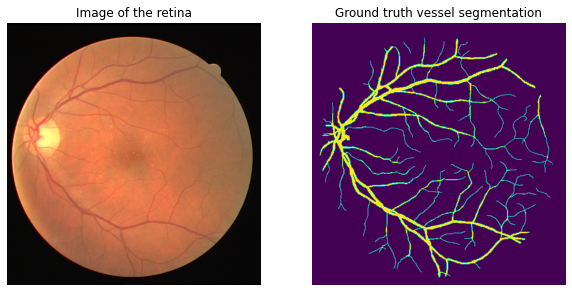

(16, 584, 565, 3)
(16, 584, 565, 1)
(16, 584, 565, 1)
(4, 584, 565, 3)
(4, 584, 565, 1)
(4, 584, 565, 1)


In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob
import sys
sys.path.append('code/')
from unet_utils import load_data

# location of the DRIVE dataset
data_folder = r"data/datasets/"
train_paths = glob(data_folder + r"training\images\*.tif")
images, masks, segmentations = load_data(train_paths)

# print the shape of image dataset
print(images.shape)

plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(images[0])

plt.subplot(1, 2, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(segmentations[0][:, :, 0])

plt.show()

# divide in training and validation
train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    images, masks, segmentations, test_size=0.2, random_state=7)

# print the shape of the training and valudation datasets
print(train_images.shape)
print(train_masks.shape)
print(train_segmentations.shape)
print(val_images.shape)
print(val_masks.shape)
print(val_segmentations.shape)

### Training a U-Net model

You are already provided with implementation of the U-Net architecture in `unet_model.py`. This is a modular implementation and can be used to generate U-Net architectures with a variety of hyperparameters such as depth and number of feature maps. Before using the model, examine the code and documentation and make sure that you understand all the details.

We will train a U-Net model using smaller patches extracted from the training images. Training the images on smaller patches requires less computation power and results in a more varied training dataset (it has the effect of data augmentation by image translation). Because a U-Net is a fully convolutional network it can be evaluated on inputs of different size (the output size will change according to the input size). Thus, although the model will be trained on smaller patches it can still be used to segment larger images with one pass through the model. 


(16, 32, 32, 3)


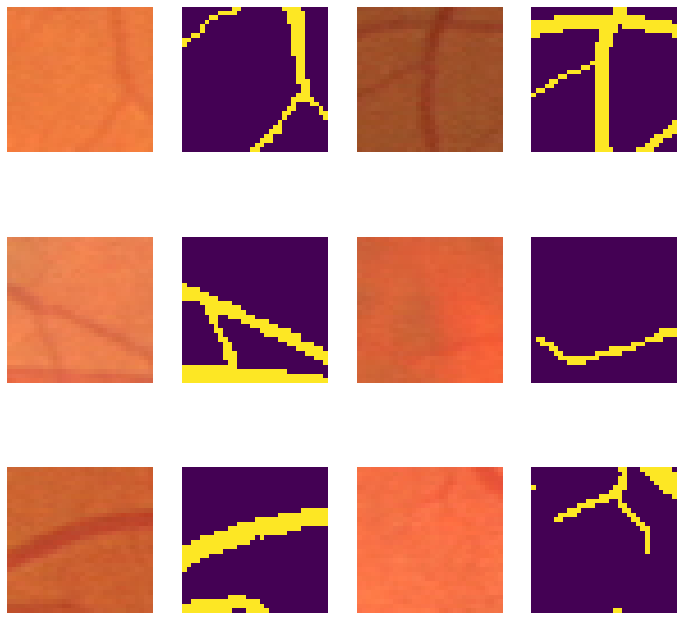

In [4]:
from unet_utils import extract_patches, preprocessing

# work with 32x32 patches
patch_size = (32, 32)

# 200 patches per image
patches_per_im = 200

# visualize a couple of patches as a visual check
patches, patches_segmentations = extract_patches(train_images, train_segmentations, patch_size, patches_per_im=1, seed=7)

print(patches.shape)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

for i in range(0, 3):
    axes[i, 0].axis('off')
    axes[i, 0].imshow(patches[i])
    axes[i, 1].axis('off')
    axes[i, 1].imshow(patches_segmentations[i][:, :, 0])
    axes[i, 2].axis('off')
    axes[i, 2].imshow(patches[i+5])
    axes[i, 3].axis('off')
    axes[i, 3].imshow(patches_segmentations[i+5][:, :, 0])

plt.show()

In [5]:
# pad the validation data to fit the U-Net model
# images of shape (584, 565) shape result in concatenation error due to the odd number of columns

print("Old shape:", val_images.shape)

val_images, val_masks, val_segmentations = preprocessing(
    val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))
    
print("New shape:", val_images.shape)

Old shape: (4, 584, 565, 3)
New shape: (4, 584, 584, 3)


In [28]:
import os
from unet_model import unet
from unet_utils import datagenerator
from keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# use a single training image, to better demonstrate the effects of data augmentation
X_train, y_train = np.expand_dims(train_images[0], axis=0), np.expand_dims(train_segmentations[0], axis=0)

print(X_train.shape)
print(y_train.shape)

# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 250
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

# work with 32x32 patches
patch_size = (32, 32)
# 200 patches per image
patches_per_im = 200

# initialize model
model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# print a summary of the model
# model.summary(line_length=120)

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# train the model with the data generator, and save the training history
history = model.fit_generator(datagenerator(X_train, y_train, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])

(1, 584, 565, 3)
(1, 584, 565, 1)


C:\Users\s160518\AppData\Local\Continuum\anaconda3\envs\my-python-3.9\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/250
50/50 - 53s - loss: 0.5526 - accuracy: 0.7872 - val_loss: 0.5284 - val_accuracy: 0.9211
Epoch 2/250
50/50 - 50s - loss: 0.3154 - accuracy: 0.9471 - val_loss: 0.2928 - val_accuracy: 0.9211
Epoch 3/250
50/50 - 46s - loss: 0.2247 - accuracy: 0.9562 - val_loss: 0.2946 - val_accuracy: 0.9211
Epoch 4/250
50/50 - 44s - loss: 0.1995 - accuracy: 0.9548 - val_loss: 8.5997 - val_accuracy: 0.1301
Epoch 5/250
50/50 - 47s - loss: 0.1751 - accuracy: 0.9526 - val_loss: 0.3156 - val_accuracy: 0.9186
Epoch 6/250
50/50 - 43s - loss: 0.1556 - accuracy: 0.9550 - val_loss: 0.3101 - val_accuracy: 0.9213
Epoch 7/250
50/50 - 47s - loss: 0.1339 - accuracy: 0.9600 - val_loss: 0.4801 - val_accuracy: 0.9219
Epoch 8/250
50/50 - 43s - loss: 0.1230 - accuracy: 0.9601 - val_loss: 0.3867 - val_accuracy: 0.9235
Epoch 9/250
50/50 - 47s - loss: 0.1419 - accuracy: 0.9545 - val_loss: 0.3350 - val_accuracy: 0.9117
Epoch 10/250
50/50 - 44s - loss: 0.1323 - accuracy: 0.9579 - val_loss: 0.2310 - val_accuracy: 0.9246

### Visualizing the segmentation results

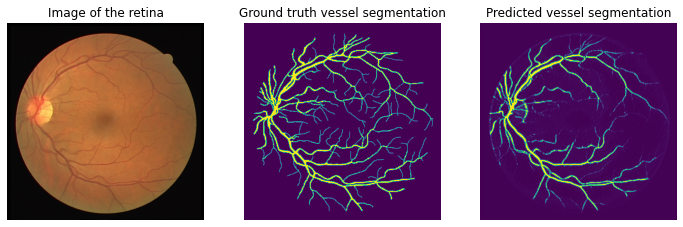

In [29]:
# run the model on one test image and show the results
from unet_utils import preprocessing

# test data paths
impaths_test = glob(data_folder + 'test\images\*.tif')

# load data
test_images, test_masks, test_segmentations = load_data(impaths_test, test=True)

# pad the data to fit the U-Net model
test_images, test_masks, test_segmentations = preprocessing(test_images, test_masks, test_segmentations, 
                                                            desired_shape=(584, 584))

# use a single image to evaluate
X_test, y_test = np.expand_dims(test_images[0], axis=0), np.expand_dims(test_masks[0], axis=0)

# predict test samples
test_prediction = model.predict(X_test, batch_size=4)

# visualize the test result
plt.figure(figsize=(12, 10))

plt.subplot(1, 3, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(test_images[0])

plt.subplot(1, 3, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(test_segmentations[0][:, :, 0])

plt.subplot(1, 3, 3)
plt.title("Predicted vessel segmentation")
plt.axis('off')
plt.imshow(test_prediction[0, :, :, 0])

plt.show()

# Exercises
## Number of parameters

The first convolutional layer in the MNIST example has 320 parameters. The first fully connected layer has 1179,776 parameters. What do these parameters correspond to? 

<font color='#770a0a'>What is the general expression for the number of parameters of 1) a convolutional layer and 2) a fully-connected layer?</font>

$\textbf{Answers:}$These parameters correspond to the number trainable parameters in the modellayer. The general expressions for these two different layers are: <br>

$\textbf{1: convolutional layer}$ number of parameters = filters x kernel size x input layer size + biases( number of filters)
in the MNIST example the parameters for the convolutional layer is given by: $32 * (3 * 3) * 1 + 32 = 320$ parameters <br>

$\textbf{2: fully-connected layer}$ number of parameters = output size * (input layer size + 1)
in the MNIST example the fully connected layer is calculated by: 
$128 * (9216 + 1) = 1179776 $ parameters

## Fully-convolutional MNIST model

Modify the model in the MNIST example in such a way that it only contains convolutional layers while keeping the same number of parameters. If you do the modification correctly, the two models will have the same behaviour (i.e. they will represent the same model, only with different implementation). Show this experimentally. 

$\textbf{Results of the original (with dense) model:}$ <br>
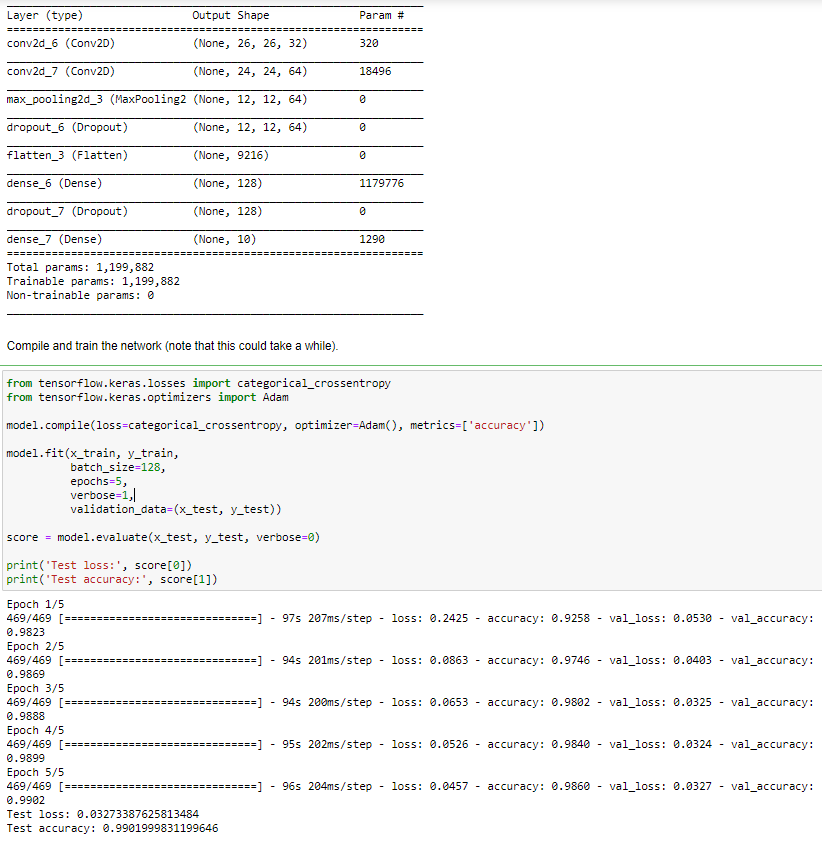

$\textbf{Results of the adapted (with only convolutional layers) model:}$ <br>


In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

# load the MNIST the dataset
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

# scale the image intensities to the 0-1 range
train_images = (train_images / 255.0).astype(np.float32)
test_images = (test_images / 255.0).astype(np.float32)

# convert the data to channel-last
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

# convert the labels to one-hot encoded
train_labels = keras.utils.to_categorical(train_labels, 10)
test_labels = keras.utils.to_categorical(test_labels, 10)

model_conv = Sequential()
model_conv.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model_conv.add(Conv2D(64, (3, 3), activation='relu'))
model_conv.add(MaxPooling2D(pool_size=(2, 2)))
model_conv.add(Dropout(0.25))
model_conv.add(Conv2D(128, (12, 12), activation='relu'))
model_conv.add(Dropout(0.5))
model_conv.add(Conv2D(10, (1, 1), activation='softmax'))
model_conv.add(Flatten())

model_conv.summary()

model_conv.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

model_conv.fit(train_images, train_labels,
          batch_size=128,
          epochs=5,
          verbose=1,
          validation_data=(test_images, test_labels))

score_conv = model_conv.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score_conv[0])
print('Test accuracy:', score_conv[1])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 1, 1, 128)         1179776   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 1, 128)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 1, 1, 10)         


## U-Net architecture

<font color='#770a0a'> What is the role of the skip connections in the U-Net neural network architecture? Will it be possible to train the exact same architecture with the skip connections omitted? If yes, what would be the expected result? If no, what would be the cause of the error?</font>


$\textbf{Answers:}$ <br>
Skip connections in the U-net add the outputs from the encoding path to the decoding path. The skip connections are able to recover the fine-grained details in the predictions. <br>
It is possible to train the exact same architecture without the skip connections. Since the skip connections recover the fine-grained details in the predictions, we expect the result of this model to be less detailed compared to the model with skip connections. <br>
In order to test what the results would look like, we did create this model without these skip connections. Below the script of this model is given. The original model code has been slightly adapted and both models are run and saved. The saved models are now loaded and the behaviour is compared. First, in the loss functions it can be seen that the normal model does converge to a slightly lower loss than the model without skip connections. Second, one predicted segmentation is visualized for both models and they are both compared with the ground truth. In these results it can be seen that both models are able to predict the overall shapes of the vessels quite well, however when looking really closely it can be seen that indeed the segmentation predicted by the model without skip connections is less detailed than the predictions made by the original model. 


In [14]:
# The u_net model slightly adapted so that it will not have any skip connections

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.layers import UpSampling2D, concatenate, add
from keras.layers import Concatenate, BatchNormalization
from keras import backend as K


def conv_block1(inp, encoder_list, channels, batchnorm, regularization, encoder_branch=False, pool=False):
    """
    Convolutional block, consists of optional max-pooling followed by two convolutional layers

    :param inp: Layer before convolutional block
    :param encoder_list: List where layer outputs for cross concatenation are saved
    :param channels: Number of channels within the block
    :param batchnorm: Optional batch-normalization
    :param regularization: Optional kernel regularization
    :param encoder_branch: Boolean, is block in the encoder branch or not
    :param pool: Boolean, whether to apply max-pooling before convolutional block
    :return: x: last (batch-normalized) convolutional layer and encoder_list: see encoder_list
    """
    # Apply max-pooling before convolutions, if specified (only in down-branch and bottom block)
    if pool:
        inp = MaxPooling2D()(inp)

    # Convolutional layer followed by optional batch-normalization
    x = Conv2D(channels, 3, activation='relu', padding='same', kernel_regularizer=regularization)(inp)
    x = BatchNormalization()(x) if batchnorm else x

    x = Conv2D(channels, 3, activation='relu', padding='same', kernel_regularizer=regularization)(x)
    x = BatchNormalization()(x) if batchnorm else x

    # Save the last Conv2D layer output for cross connections
    if encoder_branch:
        encoder_list.append(x)

    return x, encoder_list


def encoder_path1(inp, channels, depth, batchnorm, regularization):
    """
    Encoder path of the U-Net, creates the down-branch

    :param inp: Input layer
    :param channels: Number of initial channels
    :param depth: Total depth of the U-Net
    :param batchnorm: Optional batch-normalization
    :param regularization: Optional kernel regularization
    :return: encoder: last layer of the down-branch and encoder_list: output of each block for cross connections
    """
    encoder_list = []
    encoder = inp
    for l_idx in range(depth):
        if l_idx == 0:
            encoder, encoder_list = conv_block1(encoder, encoder_list, channels, batchnorm,
                                                 regularization, encoder_branch=True)
        else:
            encoder, encoder_list = conv_block1(encoder, encoder_list, channels, batchnorm,
                                                 regularization, encoder_branch=True, pool=True)

        # Increase number of channels in deeper layers
        channels *= 2

    return encoder, encoder_list


def decoder_path1(inp, encoder_list, channels, depth, batchnorm, regularization):
    """
    Decoder path of the U-Net, creates the up-branch

    :param inp: Last layer from the bottom of the U-Net
    :param encoder_list: outputs from the encoder path to form the cross connections
    :param channels: Maximum number of channels (equal to initial_channels * 2^depth)
    :param depth: Total depth of the U-Net
    :param batchnorm: Optional batch-normalization
    :param regularization: Optional kernel regularization
    :return: Last layer of the up-branch
    """
    decoder = inp
    for l_idx in range(depth):
        # Decrease number of channels in higher layers
        channels = int(channels / 2)

        # Start of with upsampling, followed by convolution, followed by batch normalization
        decoder = Conv2D(channels, 2, activation='relu', padding='same', kernel_regularizer=regularization)(
            UpSampling2D(size=(2, 2))(decoder))
        decoder = BatchNormalization()(decoder) if batchnorm else decoder

        # Concatenate
        #decoder = concatenate([encoder_list[-(l_idx + 1)], decoder], axis=3)
        
        # Convolutional block
        decoder, _ = conv_block1(decoder, encoder_list, channels, batchnorm, regularization)

    return decoder


def unet_no_skip_connections(input_shape=(512, 512, 3), depth=4, channels=64, regularization=None, batchnorm=False):
    """
    This function can create a U-Net for any amount of inputs with any desired network depth.
    Additional functionalities like batch normalization, residual layers and dropout can be selected.

    :param input_shape: Shape of the input image
    :param depth: Depth of the network, number of down- and upsample blocks
    :param channels: Number of output filters in the first convolutional block
    :param output_channels: Number of channels of the output image
    :param regularization: Optional kernel regularizer
    :param batchnorm: Optional batch normalization
    :return: Keras model
    """

    # Input layer
    inp = Input(shape=input_shape)

    # Encoder path
    encoder, encoder_list = encoder_path1(inp, channels, depth, batchnorm, regularization)

    # Bottom part, similar to encoder however output is not saved for U-Net concatenation
    channels = channels * 2**depth
    bottom, _ = conv_block1(encoder, encoder_list, channels, batchnorm, regularization, pool=True)

    # Decoder path
    decoder = decoder_path1(bottom, encoder_list, channels, depth, batchnorm, regularization)

     # Output layer
    out = Conv2D(1, 1, activation='sigmoid')(decoder)

    return Model(inputs=inp, outputs=out)

In [15]:
import os
from unet_model import unet
#from unet_model_no_skip_connections import *
from unet_utils import datagenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from unet_utils import extract_patches, preprocessing

# Function that trains the u_net model with or without skip connections
def train_Unet_model(skip_connections, X_train_data = [],y_train_data = []):
 
    # work with 32x32 patches
    patch_size = (32, 32)

    # 200 patches per image
    patches_per_im = 200

    # visualize a couple of patches as a visual check
    patches, patches_segmentations = extract_patches(X_train_data, y_train_data, patch_size, patches_per_im=1, seed=7)

    # hyperparameters
    depth = 3
    channels = 32
    use_batchnorm = True
    batch_size = 64
    epochs = 250
    patches_per_im = 200
    steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

   
    # 200 patches per image
    
    
    # initialize model
    if skip_connections == 1:
        unet_model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)
        print('normal')
    if skip_connections == 0:
        unet_model = unet_no_skip_connections(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)
        print('no_skip')

        
    # print a summary of the model
    # model.summary(line_length=120)

    # compile the model
    unet_model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    # stop the training if the validation loss does not increase for 15 consecutive epochs
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    # train the model with the data generator, and save the training history
    hist = unet_model.fit_generator(datagenerator(X_train_data, y_train_data, patch_size, patches_per_im, batch_size),
                                  validation_data=(val_images, val_segmentations),
                                  steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                                  callbacks=[early_stopping])
    return unet_model, hist

# Function that saves the model and the training and validation losses

def save_model(model, history, name):
    model.save(name)
    train_loss = history.history['loss']
    np.save(fr'train_loss_{name}', train_loss)
    val_loss = history.history['val_loss']
    np.save(fr'val_loss_{name}', val_loss)
    
    
# Train u_net model (with skip connections)
Unet_model, hist = train_Unet_model(1, train_images, train_segmentations)
save_model(Unet_model, hist, 'Unet_model')


# Train model without skip connections
Unet_model_no_skip_connections, hist1  = train_Unet_model(0, train_images, train_segmentations)
save_model(Unet_model_no_skip_connections, hist1, 'Unet_model_no_skip_connections')


normal


C:\Users\s160518\AppData\Local\Continuum\anaconda3\envs\my-python-3.9\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/250
50/50 - 59s - loss: 0.5929 - accuracy: 0.7343 - val_loss: 0.4514 - val_accuracy: 0.9211
Epoch 2/250
50/50 - 53s - loss: 0.3633 - accuracy: 0.9333 - val_loss: 0.2960 - val_accuracy: 0.9211
Epoch 3/250
50/50 - 53s - loss: 0.2573 - accuracy: 0.9504 - val_loss: 0.2897 - val_accuracy: 0.9211
Epoch 4/250
50/50 - 56s - loss: 0.2058 - accuracy: 0.9482 - val_loss: 0.3677 - val_accuracy: 0.9211
Epoch 5/250
50/50 - 56s - loss: 0.1694 - accuracy: 0.9535 - val_loss: 0.3380 - val_accuracy: 0.9213
Epoch 6/250
50/50 - 55s - loss: 0.1596 - accuracy: 0.9513 - val_loss: 0.2494 - val_accuracy: 0.9245
Epoch 7/250
50/50 - 57s - loss: 0.1427 - accuracy: 0.9535 - val_loss: 0.2830 - val_accuracy: 0.9231
Epoch 8/250
50/50 - 58s - loss: 0.1328 - accuracy: 0.9549 - val_loss: 0.2272 - val_accuracy: 0.9293
Epoch 9/250
50/50 - 56s - loss: 0.1313 - accuracy: 0.9549 - val_loss: 0.1698 - val_accuracy: 0.9478
Epoch 10/250
50/50 - 55s - loss: 0.1293 - accuracy: 0.9552 - val_loss: 0.1819 - val_accuracy: 0.9466

C:\Users\s160518\AppData\Local\Continuum\anaconda3\envs\my-python-3.9\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


50/50 - 50s - loss: 0.6234 - accuracy: 0.7181 - val_loss: 0.4831 - val_accuracy: 0.9211
Epoch 2/250
50/50 - 52s - loss: 0.4099 - accuracy: 0.9063 - val_loss: 0.4662 - val_accuracy: 0.9187
Epoch 3/250
50/50 - 55s - loss: 0.2806 - accuracy: 0.9312 - val_loss: 1.3404 - val_accuracy: 0.2456
Epoch 4/250
50/50 - 52s - loss: 0.2296 - accuracy: 0.9371 - val_loss: 0.8194 - val_accuracy: 0.6524
Epoch 5/250
50/50 - 50s - loss: 0.2022 - accuracy: 0.9362 - val_loss: 0.5780 - val_accuracy: 0.9127
Epoch 6/250
50/50 - 55s - loss: 0.1801 - accuracy: 0.9402 - val_loss: 0.5328 - val_accuracy: 0.9196
Epoch 7/250
50/50 - 55s - loss: 0.1661 - accuracy: 0.9425 - val_loss: 0.2567 - val_accuracy: 0.9278
Epoch 8/250
50/50 - 47s - loss: 0.1497 - accuracy: 0.9475 - val_loss: 0.2362 - val_accuracy: 0.9328
Epoch 9/250
50/50 - 53s - loss: 0.1482 - accuracy: 0.9469 - val_loss: 0.1476 - val_accuracy: 0.9473
Epoch 10/250
50/50 - 51s - loss: 0.1501 - accuracy: 0.9458 - val_loss: 0.1244 - val_accuracy: 0.9568
Epoch 11/25

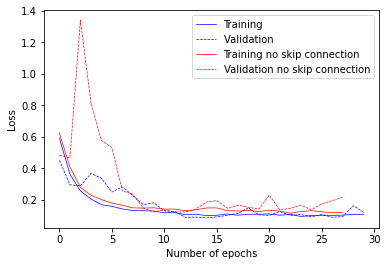

In [17]:
from tensorflow.keras.models import load_model
import numpy as np

training_loss1 = np.load("train_loss_Unet_model.npy")
validation_loss1= np.load("val_loss_Unet_model.npy")

training_loss2 = np.load("train_loss_Unet_model_no_skip_connections.npy")
validation_loss2 = np.load("val_loss_Unet_model_no_skip_connections.npy")

fig,ax=plt.subplots(1,1)
ax.plot(training_loss1,'b',linewidth=0.7,label='Training ')
ax.plot(validation_loss1,'b--',linewidth=0.7,label='Validation ')
ax.plot(training_loss2,'r',linewidth=0.7,label='Training no skip connection')
ax.plot(validation_loss2,'r--',linewidth=0.7,label='Validation no skip connection')
plt.xlabel('Number of epochs')
plt.ylabel('Loss')
plt.legend()



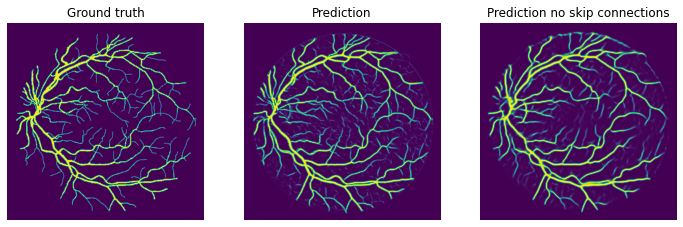

In [22]:
# run the model on one test image and show the results
from unet_utils import preprocessing
from tensorflow.keras.models import load_model



# test data paths
impaths_test = glob(data_folder + 'test\images\*.tif')

# load data
test_images, test_masks, test_segmentations = load_data(impaths_test, test=True)

# pad the data to fit the U-Net model
test_images, test_masks, test_segmentations = preprocessing(test_images, test_masks, test_segmentations, 
                                                            desired_shape=(584, 584))

# use a single image to evaluate
X_test, y_test = np.expand_dims(test_images[0], axis=0), np.expand_dims(test_masks[0], axis=0)

# load models
model_unet = load_model('Unet_model')
model_unet_no_skip_connections = load_model('Unet_model_no_skip_connections')

# predict test samples
test_prediction1 = model_unet.predict(X_test, batch_size=4)
test_prediction2 = model_unet_no_skip_connections.predict(X_test, batch_size=4)

# visualize the test result
plt.figure(figsize=(12, 10))



plt.subplot(1, 3, 1)
plt.title("Ground truth")
plt.axis('off')
plt.imshow(test_segmentations[0][:, :, 0])

plt.subplot(1, 3, 2)
plt.title("Prediction")
plt.axis('off')
plt.imshow(test_prediction1[0, :, :, 0])

plt.subplot(1, 3, 3)
plt.title("Prediction no skip connections")
plt.axis('off')
plt.imshow(test_prediction2[0, :, :, 0])

plt.show()

## Data augmentation

<font color='#770a0a'>Why does data augmentation result in less overfitting? Can data augmentation be applied to the test samples? If yes, towards what goal? If no, what is preventing that?</font>


Implement random brightness augmentation of the image data by adding a random offset to the image intensity before passing them trough the network at training time. Train a model with random brightness augmentation and compare it to the baseline above. 

Implement data augmentation procedure that in addition to brightness augmentation also performs b-spline geometric augmentation using the [`gryds`](https://github.com/tueimage/gryds) package (you can look at the documentation of the package for an example on how to do that). Compare the new model with the baseline and the model that only performs brightness augmentation.

$\textbf{Answers:}$
Data augmentation is a way to increase the size of a dataset without showing identical samples. 
It will learn more general features about the classes, therefore the model becomes more robust to small changes in the input data.
This implies that the overfitting will be less. 

Test samples are considered to be unseen real-world data and it is common practice to 'not touch' the test data. 
Therefore it is uncommon to apply data augmentation to test data. 

However, data augmentation can be applied to test samples to improve the prediction of the model. 
This is especially helpfull when the model is not confident that the sample belongs to one specific class. 
By only presenting the original sample to the model, it might predict the class wrong. 
However by presenting the test sample multiple times to the model, but each time as an augmented version of the original sample,
the model makes different errors in the prediction. By averaging the predictions of the augmented samples, the error of the prediction is also averaged. 
This results in a better estimated prediction of the original test sample.

Sidenote to the types of data augmentation is that these should not change the class of the sample.